In [34]:
from src.sec_8k_preprocess import load_8k_filings, parse_8k_filing
import polars as pl
import hvplot.polars
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_8k = load_8k_filings()
df_8k.head()

 Parquet file exists at data/preprocessed/submissions_8k.parquet. Reading...


cik_int,company_name,form,accession,filing_date,report_date,acceptance_datetime,act,file_number,film_number,items,size,is_xbrl,is_inline_xbrl,primary_document,primary_doc_description,acceptance_date,accession_no_dash,url_txt
str,str,str,str,date,date,datetime[μs],str,str,str,str,i64,i64,i64,str,str,date,str,str
"""5405""","""AMERICAN MAIZE PRODUCTS CO""","""8-K""","""0000950131-95-002984""",1995-10-27,1995-10-18,null,"""""","""001-06244""","""95584984""","""5,7""",8451,0,0,"""""","""FORM 8-K""",null,"""000095013195002984""","""https://www.sec.gov/Archives/e…"
"""5405""","""AMERICAN MAIZE PRODUCTS CO""","""8-K""","""0000950109-95-002831""",1995-07-28,1995-06-30,null,"""""","""001-06244""","""95557157""","""5""",116160,0,0,"""""","""FORM 8-K""",null,"""000095010995002831""","""https://www.sec.gov/Archives/e…"
"""5405""","""AMERICAN MAIZE PRODUCTS CO""","""8-K""","""0000890613-95-000092""",1995-07-11,1995-07-07,null,"""""","""001-06244""","""95553269""","""5,7""",27032,0,0,"""""","""FORM 8-K""",null,"""000089061395000092""","""https://www.sec.gov/Archives/e…"
"""5405""","""AMERICAN MAIZE PRODUCTS CO""","""8-K""","""0000950123-95-001123""",1995-04-25,1995-04-10,null,"""""","""001-06244""","""95531061""","""5,7""",7025,0,0,"""""","""FORM 8-K CURRENT REPORT""",null,"""000095012395001123""","""https://www.sec.gov/Archives/e…"
"""5405""","""AMERICAN MAIZE PRODUCTS CO""","""8-K""","""0000950123-95-001008""",1995-04-13,1995-04-12,null,"""""","""001-06244""","""95528563""","""5,7""",6741,0,0,"""""","""FORM 8-K""",null,"""000095012395001008""","""https://www.sec.gov/Archives/e…"


In [3]:
df_8k = df_8k.with_columns((pl.col('filing_date') - pl.col('report_date')).alias('days_between_report_and_filing'))

In [ ]:
# Filter to only include filings from 2004 onwards
df_8k = df_8k.filter(pl.col('report_date') >= pl.datetime(2004, 1, 1))

In [31]:
df_8k = df_8k.with_columns(pl.col("report_date").dt.year().alias("report_year"))
yearly_counts = df_8k.group_by('report_year').agg(pl.len().alias('count'))

In [37]:
yearly_counts.hvplot.bar(
    x="report_year",
    y="count",
    title="Yearly Counts",
    xlabel="Year",
    ylabel="Number of Reports",
    width=700,
    height=400,
    legend="top_right"
)

:Bars   [report_year]   (count)

In [ ]:
# Filter to only include filings where the report date is within 30 days before the filing date
df_8k = df_8k.with_columns(
    (pl.col("days_between_report_and_filing").dt.total_seconds() / 86400)#Convert seconds to days
    .alias("days_between_report_and_filing_days")
).filter(
    pl.col("days_between_report_and_filing_days").is_between(0, 30)#Keep only filings where the report date is within 30 days before the filing date
)

In [10]:
df_8k.select(pl.col('days_between_report_and_filing')).describe()

statistic,days_between_report_and_filing
str,str
"""count""","""1684546"""
"""null_count""","""0"""
"""mean""","""2 days, 20:07:03.636516"""
"""std""",null
"""min""","""0:00:00"""
"""25%""","""0:00:00"""
"""50%""","""1 day, 0:00:00"""
"""75%""","""4 days, 0:00:00"""
"""max""","""30 days, 0:00:00"""


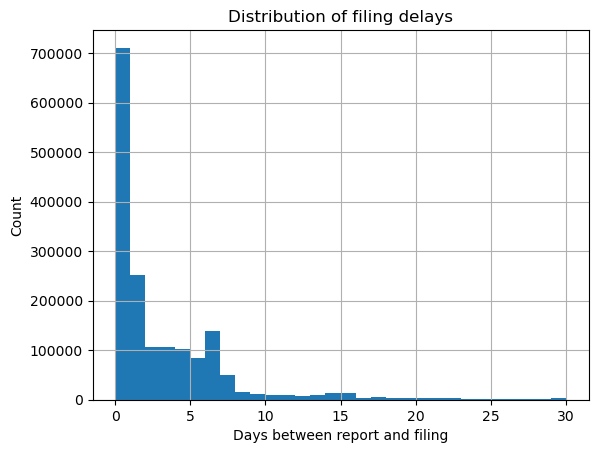

In [14]:
import matplotlib.pyplot as plt

df_8k.select(pl.col("days_between_report_and_filing_days")).to_pandas().hist(bins=30)
plt.xlabel("Days between report and filing")
plt.ylabel("Count")
plt.title("Distribution of filing delays")
plt.show()

In [17]:
# Keep only filings where the report date is at least 1 day before the filing date
df_8k = df_8k.filter(pl.col("days_between_report_and_filing_days") >= 1)

In [21]:
from src.CRSP_ITI_FNSPID_merge import process_crsp_iti_fnspid_dataset
df = process_crsp_iti_fnspid_dataset()

[INFO] Final dataset already exists at /Users/williamjallot/Desktop/semester_project/news-based-asset-pricing/data/merged/crsp_iti_fnspid.csv. Loading from disk...


In [54]:
# pip install wrds pandas
import pandas as pd
import wrds
from src.crsp_preprocess import connect_to_wrds

# ---------------------------
# Connection
# ---------------------------
db = connect_to_wrds()  

# ---------------------------
# Pull source tables
# ---------------------------

# Compustat company header: contains gvkey and cik
comp_company = db.raw_sql("""
    SELECT gvkey, cik, conm
    FROM comp.company
""")

# CRSP–Compustat Merged (CCM) linktable: GVKEY <-> PERMNO mappings over time
ccm = db.raw_sql("""
    SELECT gvkey, lpermno, linktype, linkprim, linkdt, linkenddt
    FROM crsp.ccmxpf_linktable
""")

# ---------------------------
# Filter CCM to reliable, primary links
# ---------------------------
# Common practice: keep firm links (LC, LU) and primary/common issues (P, C)
ccm_filt = (
    ccm.loc[
        ccm["linktype"].isin(["LU", "LC"]) &
        ccm["linkprim"].isin(["P", "C"])
    ]
    .rename(columns={"lpermno": "permno"})
    .dropna(subset=["permno"])
)

# Ensure dates are proper; treat open-ended linkenddt as far-future
for col in ["linkdt", "linkenddt"]:
    ccm_filt[col] = pd.to_datetime(ccm_filt[col])

ccm_filt["linkenddt"] = ccm_filt["linkenddt"].fillna(pd.Timestamp("2099-12-31"))

# ---------------------------
# Build a base CIK–PERMNO link table (time-aware)
# ---------------------------
cik_gvkey = comp_company.dropna(subset=["cik"]).drop_duplicates(subset=["gvkey", "cik"])
cik_permno = (
    cik_gvkey.merge(ccm_filt[["gvkey", "permno", "linkdt", "linkenddt"]], on="gvkey", how="inner")
)

# At this point, cik_permno contains:
#   cik, gvkey, permno, linkdt, linkenddt  (validity window for the mapping)

# ---------------------------
# Helper: map a filings DataFrame (with CIK and date) to PERMNO as of that date
def map_filings_to_permno(filings_df: pl.DataFrame, cik_permno: pl.DataFrame,
                                 cik_col: str = "cik", date_col: str = "filing_date") -> pl.DataFrame:
    """
    Map filings (CIK, date) to PERMNO and GVKEY using a Polars DataFrame join.
    
    Parameters
    ----------
    filings_df : pl.DataFrame
        DataFrame containing at least the CIK and filing_date columns.
    cik_permno : pl.DataFrame
        Mapping table with columns ['cik', 'gvkey', 'permno', 'linkdt', 'linkenddt'].
    cik_col : str
        Column name of the CIK in filings_df.
    date_col : str
        Column name of the filing date in filings_df.

    Returns
    -------
    pl.DataFrame
        filings_df with matched 'permno' and 'gvkey' columns (filtered by valid link window).
    """

    # Ensure consistent typing
    df = filings_df.with_columns([
        pl.col(cik_col).cast(pl.Utf8).str.strip(),
        pl.col(date_col).str.strptime(pl.Date, strict=False)
    ])

    link = cik_permno.with_columns([
        pl.col("cik").cast(pl.Utf8).str.strip(),
        pl.col("linkdt").cast(pl.Date),
        pl.col("linkenddt").cast(pl.Date)
    ])

    # Join filings with cik–permno mapping
    merged = df.join(link, left_on=cik_col, right_on="cik", how="left")

    # Filter by date window
    merged = merged.filter(
        (pl.col(date_col) >= pl.col("linkdt")) &
        (pl.col(date_col) <= pl.col("linkenddt"))
    )

    # Sort and deduplicate to keep most recent link (largest linkdt)
    merged = merged.sort(["gvkey", "permno", "linkdt"])
    merged = merged.unique(subset=[cik_col, date_col], keep="last")

    # Return only relevant columns
    keep_cols = list(filings_df.columns) + ["permno", "gvkey"]
    return merged.select(keep_cols)

# ---------------------------
# Example usage
# ---------------------------
# Example filings data (replace with your real DataFrame)


mapped = map_filings_to_permno(df_8k, cik_permno=cik_permno, cik_col="cik_int", date_col="filing_date")
print(mapped.head())

Connecting to WRDS as williamandwing...
postgresql://williamandwing:@wrds-pgdata.wharton.upenn.edu:9737/wrds
err=OperationalError('(psycopg2.OperationalError) connection to server at "wrds-pgdata.wharton.upenn.edu" (165.123.60.118), port 9737 failed: FATAL:  too many connections for role "williamandwing"\n')
postgresql://williamandwing:@wrds-pgdata.wharton.upenn.edu:9737/wrds
err=OperationalError('(psycopg2.OperationalError) connection to server at "wrds-pgdata.wharton.upenn.edu" (165.123.60.118), port 9737 failed: FATAL:  too many connections for role "williamandwing"\n')


OperationalError: (psycopg2.OperationalError) connection to server at "wrds-pgdata.wharton.upenn.edu" (165.123.60.118), port 9737 failed: FATAL:  too many connections for role "williamandwing"

(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [48]:
df_8k

cik_int,company_name,form,accession,filing_date,report_date,acceptance_datetime,act,file_number,film_number,items,size,is_xbrl,is_inline_xbrl,primary_document,primary_doc_description,acceptance_date,accession_no_dash,url_txt,days_between_report_and_filing,days_between_report_and_filing_days,report_year
str,str,str,str,date,date,datetime[μs],str,str,str,str,i64,i64,i64,str,str,date,str,str,duration[μs],f64,i32
"""6383""","""MOSCOW CABLECOM CORP""","""8-K""","""0000006383-07-000031""",2007-05-29,2007-05-22,null,"""34""","""000-01460""","""07883920""","""3.01,9.01""",49247,0,0,"""f8k052907nasdaqdelistinglett.h…","""FORM 8-K NASDAQ DELISTING""",null,"""000000638307000031""","""https://www.sec.gov/Archives/e…",7d,7.0,2007
"""6383""","""MOSCOW CABLECOM CORP""","""8-K""","""0000006383-07-000027""",2007-04-10,2007-04-07,null,"""34""","""000-01460""","""07759496""","""3.01,8.01,9.01""",113387,0,0,"""f8knasdaqdelistingmarchsubs.ht…","""FORM 8-K NASDAQ LETTER, MARCH …",null,"""000000638307000027""","""https://www.sec.gov/Archives/e…",3d,3.0,2007
"""6383""","""MOSCOW CABLECOM CORP""","""8-K/A""","""0000006383-07-000016""",2007-03-12,2007-03-09,null,"""34""","""000-01460""","""07685631""","""8.01,9.01""",73891,0,0,"""f8ka030907febsubscriberspres.h…","""FORM 8-K/A FEBRUARY SUBSCRIBE…",null,"""000000638307000016""","""https://www.sec.gov/Archives/e…",3d,3.0,2007
"""6383""","""MOSCOW CABLECOM CORP""","""8-K""","""0001193125-07-038497""",2007-02-23,2007-02-21,null,"""34""","""000-01460""","""07646859""","""1.01,9.01""",589755,0,0,"""d8k.htm""","""FORM 8-K""",null,"""000119312507038497""","""https://www.sec.gov/Archives/e…",2d,2.0,2007
"""6383""","""MOSCOW CABLECOM CORP""","""8-K""","""0000006383-07-000014""",2007-02-09,2007-02-08,null,"""34""","""000-01460""","""07595505""","""8.01,9.01""",61945,0,0,"""f8k020907jansubscriberspress.h…","""FORM 8-K JANUARY SUBSCRIBERS""",null,"""000000638307000014""","""https://www.sec.gov/Archives/e…",1d,1.0,2007
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2091562""","""Morgan Stanley Bank of America…","""8-K""","""0001539497-25-002805""",2025-10-30,2025-10-28,null,"""34""","""333-282944-03""","""251435183""","""8.01,9.01""",25904207,0,0,"""n5366_x9-8k.htm""","""8-K""",null,"""000153949725002805""","""https://www.sec.gov/Archives/e…",2d,2.0,2025
"""2089663""","""Capital One Prime Auto Receiva…","""8-K""","""0001193125-25-258375""",2025-10-30,2025-10-28,null,"""34""","""333-286543-01""","""251434951""","""8.01,9.01""",56727,0,0,"""d23514d8k.htm""","""8-K""",null,"""000119312525258375""","""https://www.sec.gov/Archives/e…",2d,2.0,2025
"""2089663""","""Capital One Prime Auto Receiva…","""8-K""","""0001193125-25-258363""",2025-10-30,2025-10-28,null,"""34""","""333-286543-01""","""251434857""","""1.01,8.01,9.01""",2245345,0,0,"""d58937d8k.htm""","""8-K""",null,"""000119312525258363""","""https://www.sec.gov/Archives/e…",2d,2.0,2025
